In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import h5py as h5py
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

# %load_ext autoreload
# %autoreload 2

In [2]:
data = np.load("processed_data.npz")

In [3]:
data.files


['x_train', 'y_train', 'x_test', 'y_test']

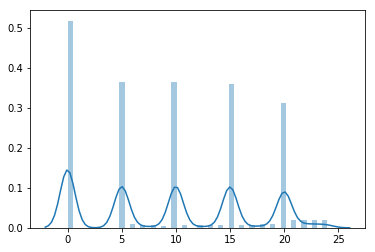

In [4]:
sns.distplot(data['x_train'][:,46:47])

In [5]:
data_path = "../cs238_sepsis_rl/data/"
final_df_train = pd.read_csv(data_path + 'train_state_action_reward_df.csv')
final_df_test = pd.read_csv(data_path+ 'test_state_action_reward_df.csv')

In [6]:
data['x_train'].shape

(153582, 47)

In [7]:
# add timestamps per episode
final_df_test['time_step'] =  final_df_test.groupby(['subject_id','hadm_id','icustay_id']).cumcount()+1
final_df_train['time_step'] =  final_df_train.groupby(['subject_id','hadm_id','icustay_id']).cumcount()+1

(array([1.3700e+04, 0.0000e+00, 1.3443e+04, 0.0000e+00, 0.0000e+00,
        1.3174e+04, 0.0000e+00, 1.2830e+04, 0.0000e+00, 0.0000e+00,
        1.2539e+04, 0.0000e+00, 0.0000e+00, 1.2220e+04, 0.0000e+00,
        1.1909e+04, 0.0000e+00, 0.0000e+00, 1.1409e+04, 0.0000e+00,
        0.0000e+00, 1.0659e+04, 0.0000e+00, 9.6770e+03, 0.0000e+00,
        0.0000e+00, 8.6580e+03, 0.0000e+00, 7.6900e+03, 0.0000e+00,
        0.0000e+00, 6.4720e+03, 0.0000e+00, 0.0000e+00, 3.4410e+03,
        0.0000e+00, 2.1310e+03, 0.0000e+00, 0.0000e+00, 1.5170e+03,
        0.0000e+00, 0.0000e+00, 1.1640e+03, 0.0000e+00, 9.4700e+02,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1.  ,  1.38,  1.76,  2.14,  2.52,  2.9 ,  3.28,  3.66,  4.04,
         4.42,  4.8 ,  5.18,  5.56,  5.94,  6.32,  6.7 ,  7.08,  7.46,
         7.84,  8.22,  8.6 ,  8.98,  9.36,  9.74, 10.12, 10.5 , 10.88,
        11.26, 11.64, 12.02, 12.4 , 12.78, 13.16, 13.54, 13.92, 14.3 ,
        14.68, 15.06, 15.44, 15.82

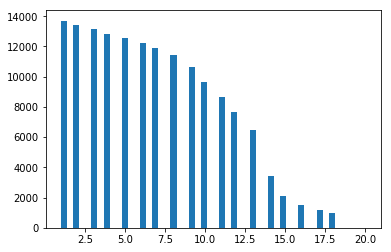

In [8]:
plt.hist(final_df_train['time_step'], bins=50)

(array([3422.,    0., 3361.,    0.,    0., 3310.,    0.,    0., 3220.,
           0.,    0., 3148.,    0.,    0., 3087.,    0.,    0., 3000.,
           0.,    0., 2900.,    0.,    0., 2728.,    0.,    0., 2497.,
           0.,    0., 2270.,    0.,    0., 2049.,    0.,    0., 1720.,
           0.,    0.,  929.,    0.,    0.,  583.,    0.,    0.,  416.,
           0.,    0.,  326.,    0.,  266.]),
 array([ 1.  ,  1.34,  1.68,  2.02,  2.36,  2.7 ,  3.04,  3.38,  3.72,
         4.06,  4.4 ,  4.74,  5.08,  5.42,  5.76,  6.1 ,  6.44,  6.78,
         7.12,  7.46,  7.8 ,  8.14,  8.48,  8.82,  9.16,  9.5 ,  9.84,
        10.18, 10.52, 10.86, 11.2 , 11.54, 11.88, 12.22, 12.56, 12.9 ,
        13.24, 13.58, 13.92, 14.26, 14.6 , 14.94, 15.28, 15.62, 15.96,
        16.3 , 16.64, 16.98, 17.32, 17.66, 18.  ]),
 <a list of 50 Patch objects>)

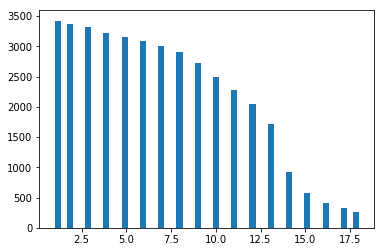

In [9]:
plt.hist(final_df_test['time_step'], bins=50)

In [10]:
# remove time steps that are 10+ steps away from end of episode
# we will only guess death based on the last 10 episodes
episode_lengths_test = final_df_test.groupby(['subject_id','hadm_id','icustay_id']).agg("count").rename(columns={"interval_start_time": "episode_length"})["episode_length"].reset_index()
episode_lengths_train = final_df_train.groupby(['subject_id','hadm_id','icustay_id']).agg("count").rename(columns={"interval_start_time": "episode_length"})["episode_length"].reset_index()

episode_rewards_test = final_df_test.groupby(['subject_id','hadm_id','icustay_id']).agg("sum").rename(columns={"reward": "total_reward"})["total_reward"].reset_index()
episode_rewards_train = final_df_train.groupby(['subject_id','hadm_id','icustay_id']).agg("sum").rename(columns={"reward": "total_reward"})["total_reward"].reset_index()



final_df_train = final_df_train.merge(episode_lengths_train, how="outer", on=['subject_id', 'hadm_id', 'icustay_id'])
final_df_test = final_df_test.merge(episode_lengths_test, how="outer", on=['subject_id', 'hadm_id', 'icustay_id'])

final_df_train = final_df_train.merge(episode_rewards_train, how="outer", on=['subject_id', 'hadm_id', 'icustay_id'])
final_df_test = final_df_test.merge(episode_rewards_test, how="outer", on=['subject_id', 'hadm_id', 'icustay_id'])

In [11]:
final_df_train['distance_from_last'] = final_df_train["episode_length"] - final_df_train["time_step"]

In [12]:
final_df_test['distance_from_last'] = final_df_test["episode_length"] - final_df_test["time_step"]

In [13]:
len(final_df_test)

39232

In [14]:
final_df_test = final_df_test[final_df_test["distance_from_last"]<10]
final_df_train = final_df_train[final_df_train["distance_from_last"]<10]

In [15]:
len(final_df_test)

30673

In [16]:
final_df_test.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'interval_start_time',
       'interval_end_time', 'ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive', 'discrete_action', 'hospital_expire_flag',
       'reward', 'row_id', 'row_id_next', 'time_step', 'episode_length',
       'total_reward', 'distance_from_last'],
      dtype='object')

In [17]:
def term(df):
    if df.reward == 0:
        return "continue"
    if abs(df.reward) == 15:
        return "done"        

# remove one anomly in the data
final_df_train=final_df_train[final_df_train["total_reward"]<=15]
final_df_test=final_df_test[final_df_test["total_reward"]<=15]
 
labels_train = final_df_train[['reward']].apply(term, axis=1).values.reshape(-1, 1)
labels_test = final_df_test[['reward']].apply(term, axis=1).values.reshape(-1, 1)

enc = OneHotEncoder()
enc.fit(labels_train)

labels_train_one_hot = enc.transform(labels_train)
labels_test_one_hot = enc.transform(labels_test)

In [18]:
enc.categories_

[array(['continue', 'done'], dtype=object)]

In [19]:
labels_train_one_hot.shape

(121550, 2)

In [20]:
final_df_train.shape

(121550, 60)

In [21]:
final_df_train.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'interval_start_time',
       'interval_end_time', 'ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive', 'discrete_action', 'hospital_expire_flag',
       'reward', 'row_id', 'row_id_next', 'time_step', 'episode_length',
       'total_reward', 'distance_from_last'],
      dtype='object')

In [22]:
max_episode = 10

features = ['ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive', 'discrete_action' ,'time_step']

def get_x_y(final_df):
    final_df_train_copy = final_df.copy()
    final_df_train_copy = final_df_train_copy.rename(columns={'row_id': 'row_id_old'})
    final_df_train_copy =  final_df_train_copy.rename(columns={'row_id_next': 'row_id'})
    key_value_train = final_df_train_copy.merge(final_df,  on=('subject_id', 'hadm_id', 'icustay_id', 'row_id'), how='left')
    train_x = key_value_train[[s + "_x" for s in features]]
    train_y = key_value_train[[s + "_y" for s in features]]
    return train_x.values, train_y.values


def get_padded_matrix(x_, y_):
    episode_matrix = np.zeros(shape=[x_.shape[0], max_episode, x_.shape[1]])
    episode = []
    labels_episode = []
    for idx in range(len(x_)):
        # within on episode
        episode.append(x_[idx])
        for event_idx in range(min(len(episode), max_episode)):
            episode_matrix[idx][-(event_idx%max_episode)-1] = episode[-event_idx - 1]
        if np.equal(x_[idx],y_[idx]).all():
            # episode changed
            episode = []
    return episode_matrix

In [23]:
final_df_train.values.shape

(121550, 60)

In [24]:
train_x, train_y = get_x_y(final_df_train)

In [25]:
test_x, test_y = get_x_y(final_df_test)

In [26]:
train_matrix = get_padded_matrix( train_x, train_y )
test_matrix = get_padded_matrix( test_x, test_y )

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                19800     
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 26,586
Trainable params: 26,586
Non-trainable params: 0
_________________________________________________________________


In [29]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
labels_train_one_hot.shape

(121550, 2)

In [31]:
labels_test_one_hot.shape

(30673, 2)

In [32]:
train_x.shape

(121550, 48)

In [33]:
early_stop =tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

cp_callback = tf.keras.callbacks.ModelCheckpoint("sepsis_termination.model",
                                                 verbose=1, monitor='val_acc', save_best_only=True)

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/termination{}".format(time()))
model.fit(train_matrix, labels_train_one_hot, epochs=10, validation_data=(test_matrix, labels_test_one_hot), callbacks=[tensorboard, cp_callback, early_stop])


Train on 121550 samples, validate on 30673 samples
Epoch 1/10
121550/121550 [==============================] - 67s 547us/step - loss: 0.1237 - acc: 0.9563 - val_loss: 0.0779 - val_acc: 0.9710

Epoch 00001: val_acc improved from -inf to 0.97105, saving model to sepsis_termination.model
Epoch 2/10
121550/121550 [==============================] - 52s 430us/step - loss: 0.0836 - acc: 0.9686 - val_loss: 0.0725 - val_acc: 0.9722

Epoch 00002: val_acc improved from 0.97105 to 0.97222, saving model to sepsis_termination.model
Epoch 3/10
121550/121550 [==============================] - 51s 417us/step - loss: 0.0792 - acc: 0.9695 - val_loss: 0.0735 - val_acc: 0.9718

Epoch 00003: val_acc did not improve from 0.97222
Epoch 4/10
121550/121550 [==============================] - 50s 413us/step - loss: 0.0765 - acc: 0.9700 - val_loss: 0.0757 - val_acc: 0.9715

Epoch 00004: val_acc did not improve from 0.97222
Epoch 5/10
121550/121550 [==============================] - 49s 407us/step - loss: 0.0743 - 